# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

### Import Packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

### Set Random Seed

In [2]:
set_seed(0)

# Prepare Data

### Define Dataset

In [3]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [4]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Visualization

In [5]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

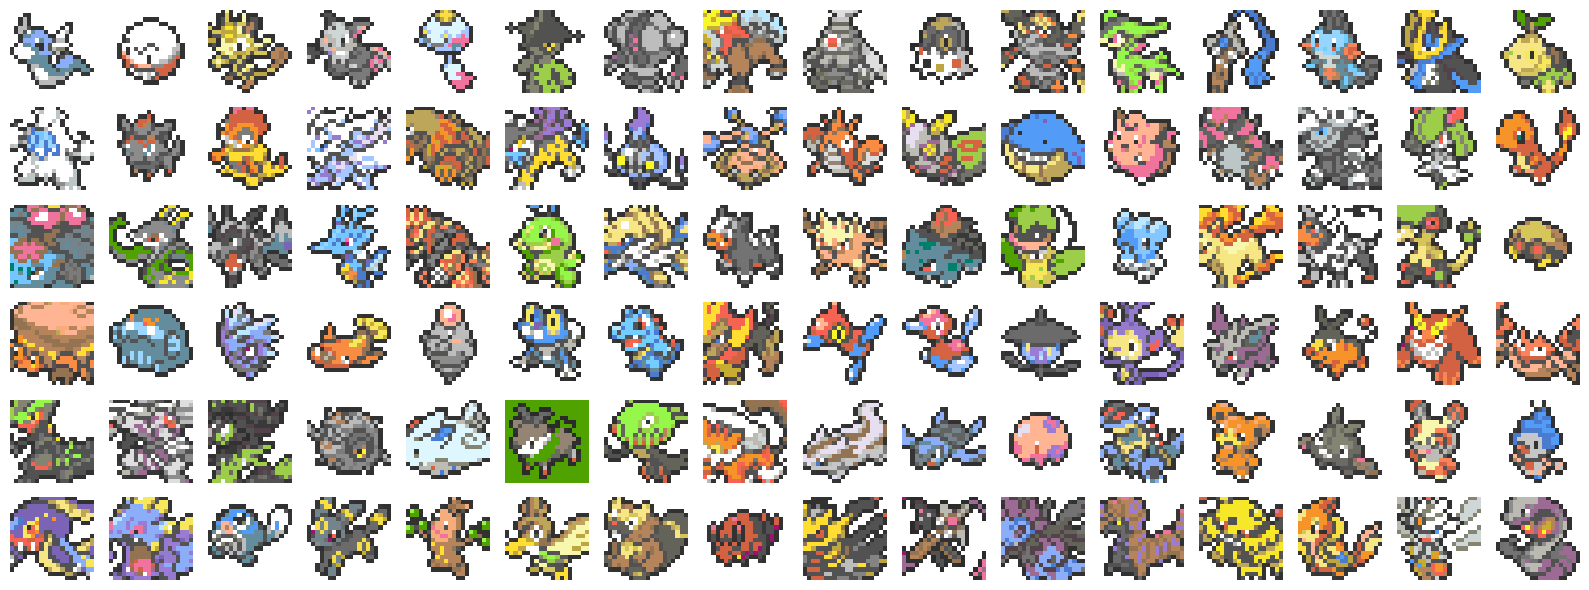

In [6]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

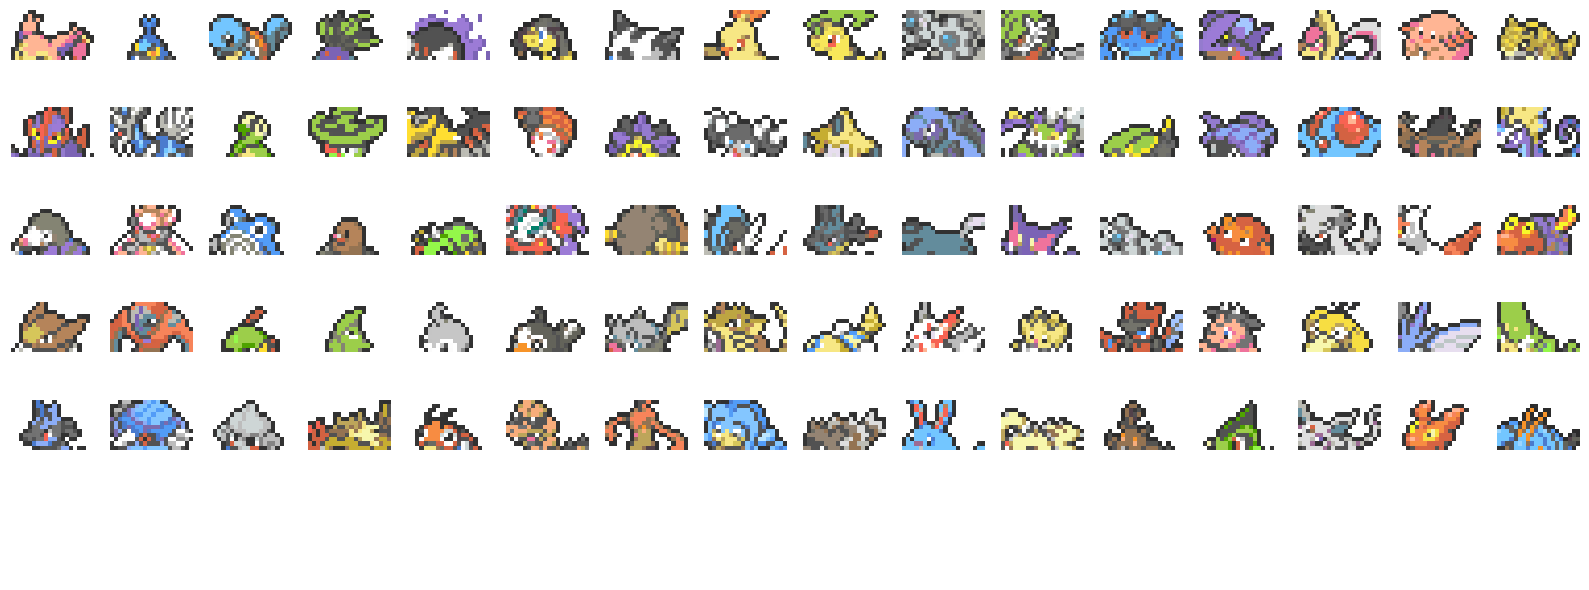

In [7]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [21]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 4,               # Number of attention heads
    "n_layer": 6,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)

### Load Model

In [22]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(167, 64)
    (wpe): Embedding(400, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=192, nx=64)
          (c_proj): Conv1D(nf=64, nx=64)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=256, nx=64)
          (c_proj): Conv1D(nf=64, nx=256)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_features=167, bias=False)
)
Trainable Parameters: 336,320


# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [23]:
# Training Parameters
epochs = 50                                     # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [25]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [26]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
checkpoint = torch.load("checkpoints/best_model.pth", map_location="cpu")
#model.load_state_dict(checkpoint['model_state_dict'])
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/50:  38%|███▊      | 15/40 [00:00<00:00, 33.99it/s]

Training Epoch 1/50: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


Epoch 1/50, Loss: 3.8084


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 1/50, Reconstruction Accuracy: 0.4109
Model saved at checkpoints/best_model.pth (Loss: 3.8084, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:01<00:00, 39.19it/s]


Epoch 2/50, Loss: 2.7562


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 2/50, Reconstruction Accuracy: 0.4065
Model saved at checkpoints/best_model.pth (Loss: 2.7562, Epoch: 2)


Training Epoch 3/50: 100%|██████████| 40/40 [00:01<00:00, 38.01it/s]


Epoch 3/50, Loss: 2.4620


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 3/50, Reconstruction Accuracy: 0.4122
Model saved at checkpoints/best_model.pth (Loss: 2.4620, Epoch: 3)


Training Epoch 4/50: 100%|██████████| 40/40 [00:01<00:00, 26.22it/s]


Epoch 4/50, Loss: 2.2990


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 4/50, Reconstruction Accuracy: 0.4052
Model saved at checkpoints/best_model.pth (Loss: 2.2990, Epoch: 4)


Training Epoch 5/50: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Epoch 5/50, Loss: 2.1872


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 5/50, Reconstruction Accuracy: 0.4052
Model saved at checkpoints/best_model.pth (Loss: 2.1872, Epoch: 5)


Training Epoch 6/50: 100%|██████████| 40/40 [00:01<00:00, 38.18it/s]


Epoch 6/50, Loss: 2.1086


Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Epoch 6/50, Reconstruction Accuracy: 0.4084
Model saved at checkpoints/best_model.pth (Loss: 2.1086, Epoch: 6)


Training Epoch 7/50: 100%|██████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch 7/50, Loss: 2.0410


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Epoch 7/50, Reconstruction Accuracy: 0.4079
Model saved at checkpoints/best_model.pth (Loss: 2.0410, Epoch: 7)


Training Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 45.35it/s]


Epoch 8/50, Loss: 1.9864


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 8/50, Reconstruction Accuracy: 0.4063
Model saved at checkpoints/best_model.pth (Loss: 1.9864, Epoch: 8)


Training Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 42.09it/s]


Epoch 9/50, Loss: 1.9454


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 9/50, Reconstruction Accuracy: 0.4006
Model saved at checkpoints/best_model.pth (Loss: 1.9454, Epoch: 9)


Training Epoch 10/50: 100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 10/50, Loss: 1.9039


Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


Epoch 10/50, Reconstruction Accuracy: 0.3877
Model saved at checkpoints/best_model.pth (Loss: 1.9039, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:01<00:00, 23.26it/s]


Epoch 11/50, Loss: 1.8759


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 11/50, Reconstruction Accuracy: 0.4092
Model saved at checkpoints/best_model.pth (Loss: 1.8759, Epoch: 11)


Training Epoch 12/50: 100%|██████████| 40/40 [00:01<00:00, 24.97it/s]


Epoch 12/50, Loss: 1.8466


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch 12/50, Reconstruction Accuracy: 0.4077
Model saved at checkpoints/best_model.pth (Loss: 1.8466, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 13/50, Loss: 1.8177


Evaluating: 100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


Epoch 13/50, Reconstruction Accuracy: 0.4066
Model saved at checkpoints/best_model.pth (Loss: 1.8177, Epoch: 13)


Training Epoch 14/50: 100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


Epoch 14/50, Loss: 1.8016


Evaluating: 100%|██████████| 5/5 [00:30<00:00,  6.04s/it]


Epoch 14/50, Reconstruction Accuracy: 0.3777
Model saved at checkpoints/best_model.pth (Loss: 1.8016, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s]


Epoch 15/50, Loss: 1.7819


Evaluating: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]


Epoch 15/50, Reconstruction Accuracy: 0.4041
Model saved at checkpoints/best_model.pth (Loss: 1.7819, Epoch: 15)


Training Epoch 16/50: 100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 16/50, Loss: 1.7602


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch 16/50, Reconstruction Accuracy: 0.3899
Model saved at checkpoints/best_model.pth (Loss: 1.7602, Epoch: 16)


Training Epoch 17/50: 100%|██████████| 40/40 [00:01<00:00, 24.87it/s]


Epoch 17/50, Loss: 1.7461


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 17/50, Reconstruction Accuracy: 0.3973
Model saved at checkpoints/best_model.pth (Loss: 1.7461, Epoch: 17)


Training Epoch 18/50: 100%|██████████| 40/40 [00:04<00:00,  8.47it/s]


Epoch 18/50, Loss: 1.7322


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch 18/50, Reconstruction Accuracy: 0.3871
Model saved at checkpoints/best_model.pth (Loss: 1.7322, Epoch: 18)


Training Epoch 19/50: 100%|██████████| 40/40 [00:01<00:00, 21.50it/s]


Epoch 19/50, Loss: 1.7209


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 19/50, Reconstruction Accuracy: 0.3570
Model saved at checkpoints/best_model.pth (Loss: 1.7209, Epoch: 19)


Training Epoch 20/50: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s]


Epoch 20/50, Loss: 1.7116


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 20/50, Reconstruction Accuracy: 0.3806
Model saved at checkpoints/best_model.pth (Loss: 1.7116, Epoch: 20)


Training Epoch 21/50: 100%|██████████| 40/40 [00:02<00:00, 14.12it/s]


Epoch 21/50, Loss: 1.6976


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Epoch 21/50, Reconstruction Accuracy: 0.3886
Model saved at checkpoints/best_model.pth (Loss: 1.6976, Epoch: 21)


Training Epoch 22/50: 100%|██████████| 40/40 [00:01<00:00, 21.77it/s]


Epoch 22/50, Loss: 1.6856


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 22/50, Reconstruction Accuracy: 0.3953
Model saved at checkpoints/best_model.pth (Loss: 1.6856, Epoch: 22)


Training Epoch 23/50: 100%|██████████| 40/40 [00:01<00:00, 32.16it/s]


Epoch 23/50, Loss: 1.6738


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 23/50, Reconstruction Accuracy: 0.3576
Model saved at checkpoints/best_model.pth (Loss: 1.6738, Epoch: 23)


Training Epoch 24/50: 100%|██████████| 40/40 [00:01<00:00, 28.56it/s]


Epoch 24/50, Loss: 1.6620


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 24/50, Reconstruction Accuracy: 0.4028
Model saved at checkpoints/best_model.pth (Loss: 1.6620, Epoch: 24)


Training Epoch 25/50: 100%|██████████| 40/40 [00:02<00:00, 17.32it/s]


Epoch 25/50, Loss: 1.6506


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 25/50, Reconstruction Accuracy: 0.3892
Model saved at checkpoints/best_model.pth (Loss: 1.6506, Epoch: 25)


Training Epoch 26/50: 100%|██████████| 40/40 [00:01<00:00, 22.01it/s]


Epoch 26/50, Loss: 1.6418


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch 26/50, Reconstruction Accuracy: 0.3990
Model saved at checkpoints/best_model.pth (Loss: 1.6418, Epoch: 26)


Training Epoch 27/50: 100%|██████████| 40/40 [00:03<00:00, 10.38it/s]


Epoch 27/50, Loss: 1.6335


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 27/50, Reconstruction Accuracy: 0.3921
Model saved at checkpoints/best_model.pth (Loss: 1.6335, Epoch: 27)


Training Epoch 28/50: 100%|██████████| 40/40 [00:01<00:00, 23.90it/s]


Epoch 28/50, Loss: 1.6245


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Epoch 28/50, Reconstruction Accuracy: 0.3755
Model saved at checkpoints/best_model.pth (Loss: 1.6245, Epoch: 28)


Training Epoch 29/50: 100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


Epoch 29/50, Loss: 1.6180


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Epoch 29/50, Reconstruction Accuracy: 0.3629
Model saved at checkpoints/best_model.pth (Loss: 1.6180, Epoch: 29)


Training Epoch 30/50: 100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 30/50, Loss: 1.6114


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 30/50, Reconstruction Accuracy: 0.3780
Model saved at checkpoints/best_model.pth (Loss: 1.6114, Epoch: 30)


Training Epoch 31/50: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s]


Epoch 31/50, Loss: 1.6024


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 31/50, Reconstruction Accuracy: 0.3910
Model saved at checkpoints/best_model.pth (Loss: 1.6024, Epoch: 31)


Training Epoch 32/50: 100%|██████████| 40/40 [00:01<00:00, 35.50it/s]


Epoch 32/50, Loss: 1.5915


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 32/50, Reconstruction Accuracy: 0.3693
Model saved at checkpoints/best_model.pth (Loss: 1.5915, Epoch: 32)


Training Epoch 33/50: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 33/50, Loss: 1.5919


Evaluating: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]


Epoch 33/50, Reconstruction Accuracy: 0.3802


Training Epoch 34/50: 100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 34/50, Loss: 1.5799


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 34/50, Reconstruction Accuracy: 0.3997
Model saved at checkpoints/best_model.pth (Loss: 1.5799, Epoch: 34)


Training Epoch 35/50: 100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


Epoch 35/50, Loss: 1.5680


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 35/50, Reconstruction Accuracy: 0.3941
Model saved at checkpoints/best_model.pth (Loss: 1.5680, Epoch: 35)


Training Epoch 36/50: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Epoch 36/50, Loss: 1.5595


Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


Epoch 36/50, Reconstruction Accuracy: 0.3753
Model saved at checkpoints/best_model.pth (Loss: 1.5595, Epoch: 36)


Training Epoch 37/50: 100%|██████████| 40/40 [00:05<00:00,  6.88it/s]


Epoch 37/50, Loss: 1.5540


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 37/50, Reconstruction Accuracy: 0.3858
Model saved at checkpoints/best_model.pth (Loss: 1.5540, Epoch: 37)


Training Epoch 38/50: 100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch 38/50, Loss: 1.5497


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch 38/50, Reconstruction Accuracy: 0.3702
Model saved at checkpoints/best_model.pth (Loss: 1.5497, Epoch: 38)


Training Epoch 39/50: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s]


Epoch 39/50, Loss: 1.5464


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 39/50, Reconstruction Accuracy: 0.3885
Model saved at checkpoints/best_model.pth (Loss: 1.5464, Epoch: 39)


Training Epoch 40/50: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s]


Epoch 40/50, Loss: 1.5343


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Epoch 40/50, Reconstruction Accuracy: 0.3735
Model saved at checkpoints/best_model.pth (Loss: 1.5343, Epoch: 40)


Training Epoch 41/50: 100%|██████████| 40/40 [00:05<00:00,  7.48it/s]


Epoch 41/50, Loss: 1.5238


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Epoch 41/50, Reconstruction Accuracy: 0.3937
Model saved at checkpoints/best_model.pth (Loss: 1.5238, Epoch: 41)


Training Epoch 42/50: 100%|██████████| 40/40 [00:02<00:00, 17.53it/s]


Epoch 42/50, Loss: 1.5245


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 42/50, Reconstruction Accuracy: 0.3540


Training Epoch 43/50: 100%|██████████| 40/40 [00:02<00:00, 14.54it/s]


Epoch 43/50, Loss: 1.5153


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 43/50, Reconstruction Accuracy: 0.3485
Model saved at checkpoints/best_model.pth (Loss: 1.5153, Epoch: 43)


Training Epoch 44/50: 100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 44/50, Loss: 1.5078


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 44/50, Reconstruction Accuracy: 0.3597
Model saved at checkpoints/best_model.pth (Loss: 1.5078, Epoch: 44)


Training Epoch 45/50: 100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Epoch 45/50, Loss: 1.5080


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 45/50, Reconstruction Accuracy: 0.3434


Training Epoch 46/50: 100%|██████████| 40/40 [00:01<00:00, 22.84it/s]


Epoch 46/50, Loss: 1.4956


Evaluating: 100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Epoch 46/50, Reconstruction Accuracy: 0.3615
Model saved at checkpoints/best_model.pth (Loss: 1.4956, Epoch: 46)


Training Epoch 47/50: 100%|██████████| 40/40 [00:01<00:00, 21.03it/s]


Epoch 47/50, Loss: 1.4835


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch 47/50, Reconstruction Accuracy: 0.3661
Model saved at checkpoints/best_model.pth (Loss: 1.4835, Epoch: 47)


Training Epoch 48/50: 100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 48/50, Loss: 1.4763


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 48/50, Reconstruction Accuracy: 0.3444
Model saved at checkpoints/best_model.pth (Loss: 1.4763, Epoch: 48)


Training Epoch 49/50: 100%|██████████| 40/40 [00:02<00:00, 17.57it/s]


Epoch 49/50, Loss: 1.4706


Evaluating: 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


Epoch 49/50, Reconstruction Accuracy: 0.3299
Model saved at checkpoints/best_model.pth (Loss: 1.4706, Epoch: 49)


Training Epoch 50/50: 100%|██████████| 40/40 [00:01<00:00, 25.72it/s]


Epoch 50/50, Loss: 1.4599


Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

Epoch 50/50, Reconstruction Accuracy: 0.3384
Model saved at checkpoints/best_model.pth (Loss: 1.4599, Epoch: 50)


### Inference

In [27]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

Reconstructed results saved to reconstructed_results.txt


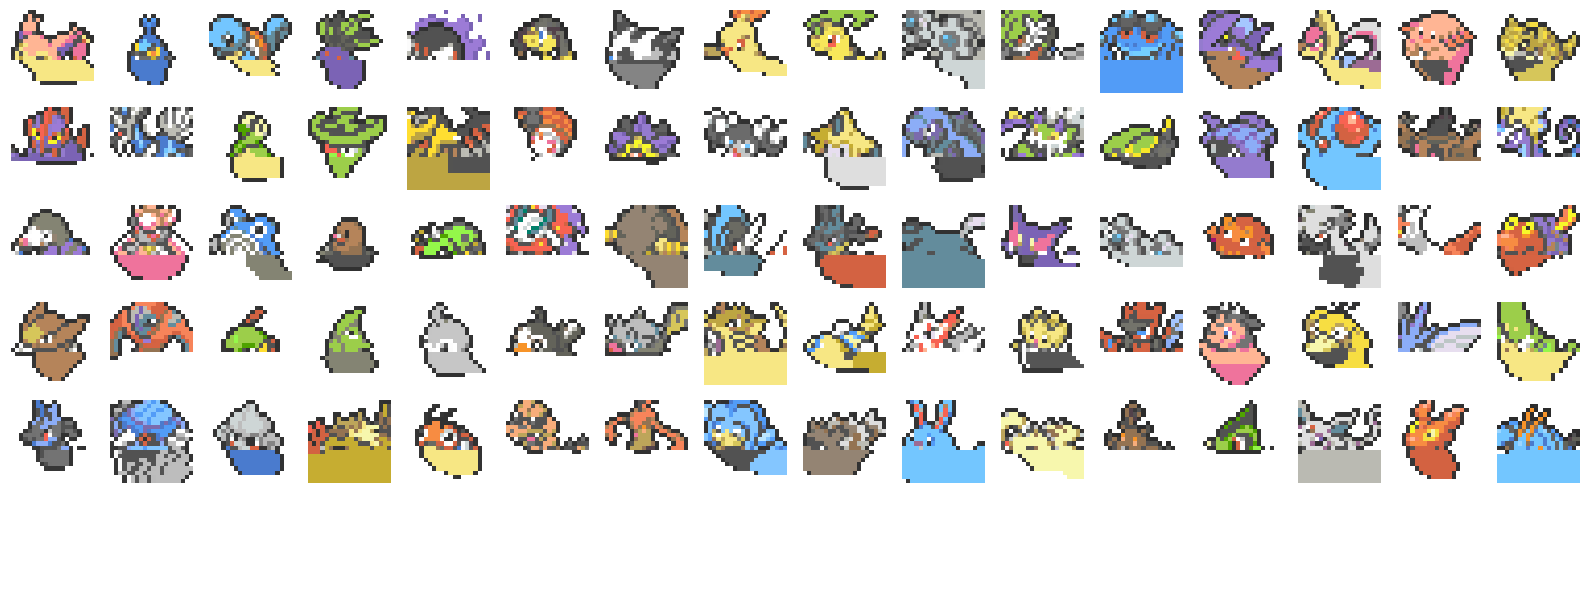

In [28]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)

In [29]:
import os
from PIL import Image

def save_images_to_folder(images, folder, prefix="img"):
    """
    将一批 PIL.Image 保存到文件夹

    Args:
        images (list[PIL.Image]): 图像列表
        folder (str): 保存目录
        prefix (str): 文件名前缀
    """
    os.makedirs(folder, exist_ok=True)
    
    for i, img in enumerate(images):
        path = os.path.join(folder, f"{prefix}_{i:05d}.png")
        img.save(path)

    print(f"✅ Saved {len(images)} images to {folder}")

In [30]:
save_images_to_folder(predicted_images, "pred_images", prefix="pred")

✅ Saved 80 images to pred_images
